# Example Use of the `Stokes_drift` Kernel

This notebook shows how the `moacean_parcels.kernels.Stokes_drift` kernel
can be used in `ParticleSet.execute()` as a custom particle behaviour kernel that
adds the effect that waves have on particle trajectories.

In [ ]:
%matplotlib inline

import sys
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4_3D

from moacean_parcels.kernels import DeleteParticle, Stokes_drift

##### Dictionary with the paths


In [28]:
#Careful with changes in the keys, these are used throughout the notebook. 
paths = {'NEMO': '/results2/SalishSea/nowcast-green.201905/',
        'coords': '/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
        'coordsWW3': '/ocean/jvalenti/MOAD/grid/WW3_grid.nc',
        'mask': '/ocean/jvalenti/MOAD/grid/mesh_mask201702.nc',
        'out': '/home/jvalenti/MOAD/results',
        'home': '/home/jvalenti/MOAD/analysis-jose/notebooks/parcels',
        'anim': '/home/jvalenti/MOAD/animations'}

##### Some useful functions

In [29]:

def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, f'{folder}/SalishSea_1{res}_{datestr}')
    
    return prefix

def get_WW3_path(date):
    """Construct WW3 results path given the date
    e.g., /opp/wwatch3/nowcast/SoG_ww3_fields_YYYYMMDD_YYYYMMDD.nc
    :arg date: date of WW3 record
    :type date: :py:class:`datetime.datetime`
    :returns: WW3 path
    :rtype: str
    """

    # Make WW3 path
    path = '/opp/wwatch3/nowcast'
    datestr = [date.strftime(fmt) for fmt in ('%d%b%y', '%Y%m%d_%Y%m%d')]
    path = os.path.join(path, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
    if not os.path.exists(path):
        raise ValueError(f"No WW3 record found for the specified date {date.strftime('%Y-%b-%d')}")

    return path


def p_deploy(N,n,dmin,dd,r = 1000):
    '''p_deploy returns a random deviation for the number of deploting sites and particles and the depth'''

    #r is radius of particle cloud [m]
    deg2m = 111000 * np.cos(50 * np.pi / 180)
    var = (r / (deg2m * 3))**2
    x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
    if isinstance(dmin,int):
        zvals1 = dmin + np.random.random_sample([n,N]).T*(dd)
    else:
        zvals = []
        zvals1 = []
        for dept in dmin:
            zvals.append(dept + np.random.random_sample([n]).T*(dd))
        for i in range(len(zvals)):   
            zvals1=np.concatenate((zvals1[:],zvals[i]))
    return x_offset, y_offset, zvals1 

def filename_set(start,length,varlist=['U','V','W']):
    '''filename,variables,dimensions = filename_set(start,duration,varlist=['U','V','W'])
    Modify function to include more default variables
    define start as: e.g, datetime(2018, 1, 17); length= number of days'''
    
    duration = timedelta(days=length)
    #Build filenames
    Rlist,Tlist,Ulist, Vlist, Wlist = [], [], [], [], []
    Waveslist = []
   
    for day in range(duration.days):
        path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
        Ulist.append(path_NEMO + '_grid_U.nc')
        Vlist.append(path_NEMO + '_grid_V.nc')
        Wlist.append(path_NEMO + '_grid_W.nc')
        Tlist.append(path_NEMO + '_grid_T.nc')
        Rlist.append(path_NEMO + '_carp_T.nc')
        Waveslist.append(get_WW3_path(start + timedelta(days=day)))
        

    filenames = {
        'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist}, # NEMO u velocity  
        'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist}, # NEMO v velocity  
        'W': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Wlist}, # NEMO w velocity  
        'T': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Tlist}, # NEMO Temperature 
        'S': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Tlist}, # NEMO Salinity 
        'R': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Rlist}, # NEMO Density 
        'Bathy' : {'lon': paths['coords'], 'lat': paths['coords'], 'data': paths['mask']}, # NEMO Bathymetry 
        'US' : {'lon': paths['coordsWW3'], 'lat': paths['coordsWW3'], 'data': Waveslist}, # WW3 u component Stokes drift 
        'VS' : {'lon': paths['coordsWW3'], 'lat': paths['coordsWW3'], 'data': Waveslist}, # WW3 v component Stokes drift 
        'WL' : {'lon': paths['coordsWW3'], 'lat': paths['coordsWW3'], 'data': Waveslist}, # WW3 wavelength field
    }
    variables = {'U': 'vozocrtx', 'V': 'vomecrty','W': 'vovecrtz','T':'votemper','S':'vosaline','R':'sigma_theta','US':'uuss','VS':'vuss','WL':'lm','Bathy':'mbathy'}
    for fvar in varlist:
        if fvar == 'U':
            dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
        elif fvar == 'US':
            dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
        elif fvar == 'Bathy':
            dimensions = {'lon': 'glamf', 'lat': 'gphif','time': 'time_counter'}
    
    file2,var2 = {},{}
    for var in varlist:
        file2[var]=filenames[var]
        var2[var]=variables[var]
    return file2,var2,dimensions

In [30]:
#Find Vancity outfall coordinates
coords=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=coords['nav_lat'][445,304]
outf_lon=coords['nav_lon'][445,304]

##### Define particles deploying locations

In [31]:
start = datetime(2018, 12, 23) #Start date
# Set Time length [days] and timestep [seconds]
length = 10
duration = timedelta(days=length)
dt = 90 #toggle between - or + to pick backwards or forwards
N = 6 # number of deploying locations
n = 30 # 1000   # number of particles per location
dmin = [0,0,0,0,0,70] #minimum depth
dd = 20 #max depth difference from dmin
x_offset, y_offset, z = p_deploy(N,n,dmin,dd)

# Choose horizontal centre of the particle cloud
clon = [-123.901172,-125.155849,-123.207648,-122.427508,-123.399769,float(outf_lon)]
clat = [49.186308,49.975326,49.305448,47.622403,48.399420,float(outf_lat)]  

# Add the offset to obtain a random distribution for the particles at each deploy site
lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

In [32]:
#Set start date time and the name of the output file
name = 'Waves' #name output file
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile_w = os.path.join(paths['out'], fn)

##### Setting up NEMO and WW3 fields

In [33]:
#Fill in the list of variables from NEMO that you want to use as fields (If you get the a NameError, make sure that the field paths are included in filename_set() function)
varlist=['U','V','W']
filenames,variables,dimensions=filename_set(start,length,varlist)
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

#Fill in the list of variables from WW3 that you want to use as fields
varlist=['US','VS','WL']
filenames,variables,dimensions=filename_set(start,length,varlist)

#Load the fields from the WW3 data
us = Field.from_netcdf(filenames['US'], variables['US'], dimensions,allow_time_extrapolation=True)
vs = Field.from_netcdf(filenames['VS'], variables['VS'], dimensions,allow_time_extrapolation=True)
wl = Field.from_netcdf(filenames['WL'], variables['WL'], dimensions,allow_time_extrapolation=True)

#You can either add the fields by themselves or as a Vectorfield the second option is more convenient to use inside the kernel
#field_set.add_field(us) #field_set.add_field(vs) #field_set.add_field(wl)
field_set.add_vector_field(VectorField("stokes", us, vs, wl))

In [34]:
pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=2))

kernel_Sd = pset.Kernel(Stokes_drift)

pset.execute(AdvectionRK4_3D + kernel_Sd, 
             runtime=duration, 
             dt=dt,
             output_file=pset.ParticleFile(name=outfile_w, outputdt=timedelta(hours=1)),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

ds_waves = xr.open_dataset(outfile_w)

INFO: Compiled ArrayJITParticleAdvectionRK4_3DStokes_drift ==> /tmp/parcels-2894/lib2f08b88536db5911e0811f06259d7389_0.so
INFO: Temporary output files are stored in /home/jvalenti/MOAD/results/out-XFYIYVWF.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jvalenti/MOAD/results/out-XFYIYVWF" to convert these to a NetCDF file during the run.
 84% (727200.0 of 864000.0) |##########  | Elapsed Time: 0:07:41 ETA:   0:01:26

Correct cell not found for (-124.753828, 48.468040) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 407 0
            new particle indices: (yi, xi) 407 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3016801765562292e+01 6.5557060746711349e-01
Particle [1325] lost!! (lon, lat: -124.7538277359404, 48.46804007302743, depth: 2.7614799066009397, time: 733320.0s)


100% (864000.0 of 864000.0) |############| Elapsed Time: 0:09:04 Time:  0:09:04
/home/jvalenti/conda_envs/moacean-parcels/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [35]:
#Set start date time and the name of the output file
name = 'No_Waves' #name output file
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile_nw = os.path.join(paths['out'], fn)

#Fill in the list of variables from NEMO that you want to use as fields (If you get the a NameError, make sure that the field paths are included in filename_set() function)
varlist=['U','V','W']
filenames,variables,dimensions=filename_set(start,length,varlist)
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=2))

pset.execute(AdvectionRK4_3D, 
             runtime=duration, 
             dt=dt,
             output_file=pset.ParticleFile(name=outfile_nw, outputdt=timedelta(hours=1)),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-2894/libe2019950271c3fc589c3abed45ca9958_0.so
INFO: Temporary output files are stored in /home/jvalenti/MOAD/results/out-EBAYHSOE.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jvalenti/MOAD/results/out-EBAYHSOE" to convert these to a NetCDF file during the run.
 99% (856800.0 of 864000.0) |########### | Elapsed Time: 0:07:06 ETA:   0:00:02

Correct cell not found for (-124.794990, 48.517108) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 419 0
            new particle indices: (yi, xi) 419 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4041255432798806e+01 9.8212795785778861e-01
Particle [1515] lost!! (lon, lat: -124.79480502441356, 48.516886799505734, depth: 31.986900803845217, time: 859500.0s)


100% (864000.0 of 864000.0) |############| Elapsed Time: 0:07:07 Time:  0:07:07
/home/jvalenti/conda_envs/moacean-parcels/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [36]:
ds_nowaves = xr.open_dataset(outfile_nw)
ds_waves = xr.open_dataset(outfile_w)
mask = xr.open_dataset(paths['mask'])
colores=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

##### More useful functions

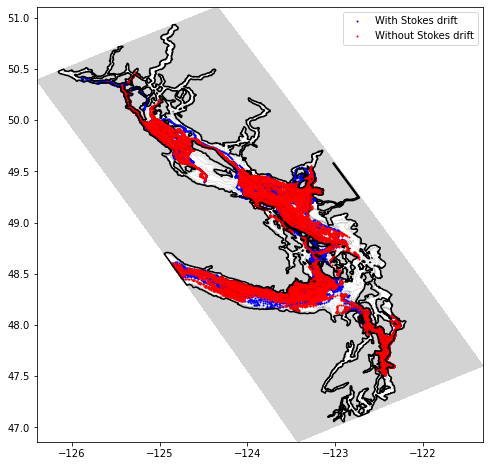

In [45]:
fig, ax1 = plt.subplots(1,figsize=(8, 8))
ax1.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax1.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax1.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

ax1.scatter(ds_waves.lon,ds_waves.lat,c='b',s=1,label='With Stokes drift')
ax1.scatter(ds_nowaves.lon,ds_nowaves.lat,c='r',s=1,label='Without Stokes drift')
plt.legend()